# Going Deeper_02. 없다면 어떻게 될까? (ResNet Ablation Study)

## 프로젝트: ResNet Ablation Study   
밑에 숫자) 이렇게 되어있는 것들은 lms노드에 순서를 따라적은거임! ex) 0)     
그리고 그냥 숫자. 이렇게 되어있는 것들은 머신러닝 프로젝트 할 때 기본과정 따라서 한 것!!     

#### 데이터 불러오기 -> 데이터 전처리 -> 모델 설계 -> 모델 학습 -> 모델 평가 -> 모델 베포

ResNet 의 성능을 평가하기 위해서 원래 논문과 동일한 이미지넷의 훈련과 검증 데이터셋을 사용하면 평가와 학습에 더 좋겠지만! 컴퓨팅 자원이 부족하니까 이미지넷보다는 적당한 크기의 CIFAR-10 데이터셋으로 평가할 것이다.

#### 우리의 실험 : CIFAR-10 에 대해서 일반 네트워크와 ResNet 을 구현해서 이 둘을 비교해서 ResNet 및 residual connection 의 유효성을 확인하는 것이다!

### 0) 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
## 필요한 라이브러리 import

## TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

print("뿅!")

뿅!


In [3]:
## GPU 가 있는지 확인해보는거
## Tensorflow가 활용할 GPU가 장착되어 있는지 확인해보자!

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 불러오기

In [4]:
## import urllib3
##urllib3.disable_warnings()      <- 이 코드는 까먹고 나중에 발견해서.....못 돌림..

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## tfds를 보면 아주 유용하게 사용이 가능하다.
## split 을 할 때 train : 80% , 뭐 이렇게 나눠서도 할 수 있음
## shuffle_files 가 True니까 file 을 shuffle 해준다.
## 모르면 tfds.load() 에서 shuffle_files를 검색하면 더 찾아보면 된다.
## info 가  참이라서 ds_info를 가져올 수 있구나!

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
## Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해보자!
## features 라는거를 ds_info로 가져온다? 

print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
## 데이터 개수 확인

print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
ds_info.features["label"].num_classes

2

In [8]:
ds_info.features["label"].names

['cat', 'dog']

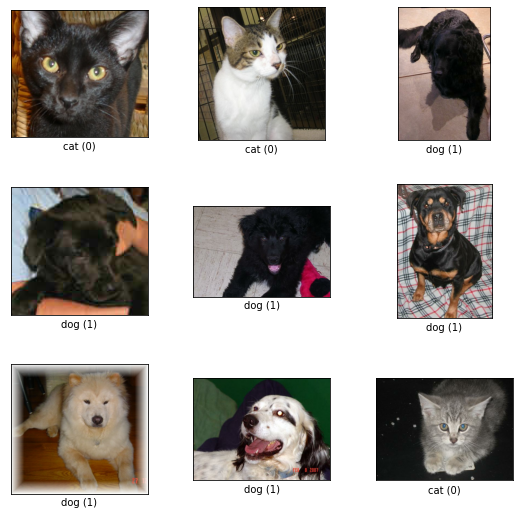

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

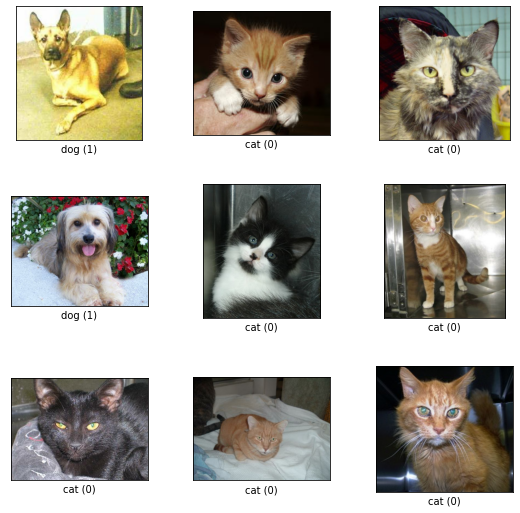

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. 데이터 전처리

### -Input Normalization

In [21]:
## 이름을 보고 뭐하는지 알고 난 다음에! image랑 label을 가지고!
## 그리고 2개를 반환한다.
## tf.cast 를 보면 변환하는거? 그래서 변환해서 2개의 이미지를 반환한다.

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [1]:
## type(ds_train)

In [22]:
## normalize 를 직접 시도

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 3. 모델 설계

### 1) ResNet 기본 블록 구성하기    
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해보자!   

우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아보자

일반적인 딥러닝 모델에서 주요 구조를 모듈화 시켜서 조금씩 바꿔 쓸 수 있는 단위를 블록(block) 이라고 부른다. 레이어(layer)는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 기본적으로 제공하는 단위이다.      
** 한 단계 위인 "블록(block)" 을 단위로 모델을 만들 수 있어야 한다. **

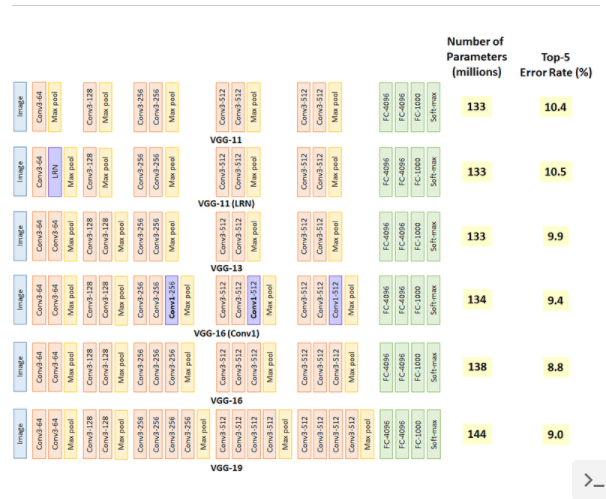

In [2]:
from IPython.display import Image
Image(filename='1.png')

VGG 는 합성곱 계층과 풀링 계층으로 구성되는 기본적인 CNN 이다.    
다만, 비중이 있는 층 (합성곱 계층, 완전연결 계층) 을 모두 16층 (19층) 으로 심화한 게 특징이다.     
- 층의 깊이에 따라서 'VGG16' 과 'VGG19' 로 구분되어진다.

In [11]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [12]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    ## ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    ## ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [13]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    ## first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    ## config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 2) ResNet-34, ResNet-50 Complete Model

#### 1. ResNet_34

In [14]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

#### 2. ResNet_50

In [15]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기    

- 블록 코드 수정하기     
우리는 앞에서 ResNet 모델을 구현했다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요하다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해보자!       

- 전체 함수 코드 수정하기      
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정하자. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보자!. 이때 입력 이미지의 크기는 (224, 224, 3)으로 하자!

In [16]:
## resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    ## plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    ## plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [17]:
def build_plainnet(input_shape=(32, 32, 3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    ## first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    ## config list들의 길이만큼 반복해서 plain block 블록을 생성한다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

#### 3. plain_34

In [18]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

#### 4. plain_50

In [19]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [20]:
del resnet_34
del resnet_50
del plain_34
del plain_50

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34      
- Ablation Study    
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.     

- 시각화    
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

- 추가 실험   
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

## 4. 모델 학습

In [23]:
BATCH_SIZE = 16     ## 한 번에 데이터를 몇 개 볼 것인가? 
EPOCH = 10          ## 몇 번 볼 것인가?

In [24]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### 1. ResNet_34

In [25]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

In [26]:
## compile 은 학습을 어떻게 시킬지에 대한 것
## loss를 정의하는 것과 굉장히 근접하다.
## loss를 작게하는 방법으로 모델을 학습? 
## optimizer에 따라서 학습을 어떻게 시킬지에 대해 영향을 준다.
## object detection
## metrics 이 accuracy? 

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

## fit 은 모델을 학습을 시키는 코드

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
 195/1163 [====>.........................] - ETA: 1:35 - loss: 2.3496 - accuracy: 0.5593

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:29 - loss: 2.2687 - accuracy: 0.5649 ETA: 1:30 - loss: 2.2759 - accu

 280/1163 [======>.......................] - ETA: 1:27 - loss: 2.2375 - accuracy: 0.5696

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:13 - loss: 2.0694 - accuracy: 0.5734

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 32s - loss: 1.7176 - accuracy: 0.5875

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 30s - loss: 1.7036 - accuracy: 0.5874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 27s - loss: 1.6871 - accuracy: 0.5878

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 22s - loss: 1.6553 - accuracy: 0.5883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 20s - loss: 1.6484 - accuracy: 0.5883

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.5488 - accuracy: 0.5864

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 169s 115ms/step - loss: 1.5488 - accuracy: 0.5864 - val_loss: 1.1732 - val_accuracy: 0.5528
Epoch 2/10
 200/1163 [====>.........................] - ETA: 1:40 - loss: 0.9943 - accuracy: 0.6019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 1:34 - loss: 0.9840 - accuracy: 0.6076

 281/1163 [======>.......................] - ETA: 1:32 - loss: 0.9758 - accuracy: 0.6108

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:17 - loss: 0.9536 - accuracy: 0.6031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 33s - loss: 0.9029 - accuracy: 0.6057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 31s - loss: 0.8999 - accuracy: 0.6067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 28s - loss: 0.8963 - accuracy: 0.6086

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 22s - loss: 0.8909 - accuracy: 0.6110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 21s - loss: 0.8897 - accuracy: 0.6109

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8712 - accuracy: 0.6166

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.8712 - accuracy: 0.6166 - val_loss: 1.1006 - val_accuracy: 0.5110
Epoch 3/10
 197/1163 [====>.........................] - ETA: 1:41 - loss: 0.7610 - accuracy: 0.6494

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:34 - loss: 0.7583 - accuracy: 0.6551

 279/1163 [======>.......................] - ETA: 1:32 - loss: 0.7561 - accuracy: 0.6589

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:16 - loss: 0.7523 - accuracy: 0.6607

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 33s - loss: 0.7410 - accuracy: 0.6699

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 31s - loss: 0.7400 - accuracy: 0.6706

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 28s - loss: 0.7399 - accuracy: 0.6697

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 23s - loss: 0.7397 - accuracy: 0.6706

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 21s - loss: 0.7395 - accuracy: 0.6707

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.6732

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.7346 - accuracy: 0.6732 - val_loss: 1.4204 - val_accuracy: 0.5427
Epoch 4/10
 196/1163 [====>.........................] - ETA: 1:41 - loss: 0.7040 - accuracy: 0.6821

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:34 - loss: 0.6945 - accuracy: 0.6925

 285/1163 [======>.......................] - ETA: 1:32 - loss: 0.6927 - accuracy: 0.6961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 1:17 - loss: 0.6895 - accuracy: 0.6989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 33s - loss: 0.6944 - accuracy: 0.6996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 30s - loss: 0.6935 - accuracy: 0.7008

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 28s - loss: 0.6931 - accuracy: 0.7003

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.6915 - accuracy: 0.7018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 21s - loss: 0.6913 - accuracy: 0.7021

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.7039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.6895 - accuracy: 0.7039 - val_loss: 0.8880 - val_accuracy: 0.5707
Epoch 5/10
 198/1163 [====>.........................] - ETA: 1:41 - loss: 0.6956 - accuracy: 0.7036

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:35 - loss: 0.6774 - accuracy: 0.7166

 285/1163 [======>.......................] - ETA: 1:32 - loss: 0.6707 - accuracy: 0.7173

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:16 - loss: 0.6694 - accuracy: 0.7193

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 33s - loss: 0.6521 - accuracy: 0.7313

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 30s - loss: 0.6507 - accuracy: 0.7319

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 28s - loss: 0.6508 - accuracy: 0.7326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.6491 - accuracy: 0.7326

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 21s - loss: 0.6486 - accuracy: 0.7328

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.7391

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.6400 - accuracy: 0.7391 - val_loss: 0.7267 - val_accuracy: 0.7196
Epoch 6/10
 199/1163 [====>.........................] - ETA: 1:40 - loss: 0.6286 - accuracy: 0.7571

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:34 - loss: 0.6256 - accuracy: 0.7525

 287/1163 [======>.......................] - ETA: 1:31 - loss: 0.6235 - accuracy: 0.7536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:16 - loss: 0.6151 - accuracy: 0.7583

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 33s - loss: 0.5958 - accuracy: 0.7647

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 30s - loss: 0.5947 - accuracy: 0.7650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 28s - loss: 0.5936 - accuracy: 0.7656

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 22s - loss: 0.5950 - accuracy: 0.7651

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 21s - loss: 0.5943 - accuracy: 0.7654

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7676

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.5914 - accuracy: 0.7676 - val_loss: 0.9882 - val_accuracy: 0.5442
Epoch 7/10
 200/1163 [====>.........................] - ETA: 1:40 - loss: 0.5678 - accuracy: 0.7853

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:34 - loss: 0.5639 - accuracy: 0.7878

 287/1163 [======>.......................] - ETA: 1:31 - loss: 0.5622 - accuracy: 0.7864

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:16 - loss: 0.5621 - accuracy: 0.7838

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 32s - loss: 0.5535 - accuracy: 0.7874

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 30s - loss: 0.5538 - accuracy: 0.7871

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 28s - loss: 0.5558 - accuracy: 0.7864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.5545 - accuracy: 0.7879

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 21s - loss: 0.5535 - accuracy: 0.7885

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.5517 - accuracy: 0.7896 - val_loss: 1.0626 - val_accuracy: 0.7164
Epoch 8/10
 205/1163 [====>.........................] - ETA: 1:40 - loss: 0.5434 - accuracy: 0.8052

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:34 - loss: 0.5412 - accuracy: 0.8073

 290/1163 [======>.......................] - ETA: 1:31 - loss: 0.5413 - accuracy: 0.8050

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:16 - loss: 0.5298 - accuracy: 0.8080

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 33s - loss: 0.5243 - accuracy: 0.8097

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 875/1163 [=====================>........] - ETA: 30s - loss: 0.5250 - accuracy: 0.8086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 27s - loss: 0.5247 - accuracy: 0.8087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 22s - loss: 0.5230 - accuracy: 0.8086

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 20s - loss: 0.5234 - accuracy: 0.8082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.8090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.5217 - accuracy: 0.8090 - val_loss: 1.3539 - val_accuracy: 0.5045
Epoch 9/10
 204/1163 [====>.........................] - ETA: 1:40 - loss: 0.4982 - accuracy: 0.8214

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:34 - loss: 0.4951 - accuracy: 0.8234

 290/1163 [======>.......................] - ETA: 1:31 - loss: 0.4913 - accuracy: 0.8244

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:16 - loss: 0.4947 - accuracy: 0.8229

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 33s - loss: 0.4971 - accuracy: 0.8211

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 30s - loss: 0.4978 - accuracy: 0.8211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 27s - loss: 0.4968 - accuracy: 0.8215

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 21s - loss: 0.4961 - accuracy: 0.8219

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1163 [=======================>......] - ETA: 20s - loss: 0.4946 - accuracy: 0.8229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.8235

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.4938 - accuracy: 0.8235 - val_loss: 0.6721 - val_accuracy: 0.6788
Epoch 10/10
 208/1163 [====>.........................] - ETA: 1:39 - loss: 0.4879 - accuracy: 0.8266

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 1:33 - loss: 0.4816 - accuracy: 0.8285

 289/1163 [======>.......................] - ETA: 1:31 - loss: 0.4793 - accuracy: 0.8281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:16 - loss: 0.4627 - accuracy: 0.8358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 32s - loss: 0.4614 - accuracy: 0.8383

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 30s - loss: 0.4618 - accuracy: 0.8382

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 27s - loss: 0.4624 - accuracy: 0.8383

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 22s - loss: 0.4614 - accuracy: 0.8388

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 20s - loss: 0.4611 - accuracy: 0.8388

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8393

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.4577 - accuracy: 0.8393 - val_loss: 0.5063 - val_accuracy: 0.8156


모델 평가가 아니라 학습에 넣는게 맞다라고 생각한다. 왜냐면 모델 평가는 test데이터로 해야한다고 생각?      
- train 은 모델을 학습   
- validation 은 모델이 잘 학습이 되고 있는지 확인? 모니터링?     
    - tf 의 EarlyStopping은 validation 을 가지고 멈춘다.       
    - 이런거를 보면 학습에 val_loss가 관여를 한다.      
- test는 모델을 평가?       
    - 이게 모델 평가에 영향을 주는거     
    - 우리가 일상생활에 사용하는 그런 데이터로 확인을 해서 모델을 평가함

In [27]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })

#### 2. ResNet_50

In [28]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [29]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 194/1163 [====>.........................] - ETA: 1:13 - loss: 5.9609 - accuracy: 0.5641

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:08 - loss: 5.7947 - accuracy: 0.5742

 279/1163 [======>.......................] - ETA: 1:07 - loss: 5.7362 - accuracy: 0.5762

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 55s - loss: 5.3635 - accuracy: 0.5893

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 24s - loss: 4.4962 - accuracy: 0.6147

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 22s - loss: 4.4559 - accuracy: 0.6164

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 4.4081 - accuracy: 0.6176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 4.3118 - accuracy: 0.6218

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 15s - loss: 4.2918 - accuracy: 0.6217

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 3.9789 - accuracy: 0.6291

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 108s 85ms/step - loss: 3.9789 - accuracy: 0.6291 - val_loss: 2.4263 - val_accuracy: 0.5274
Epoch 2/10
 194/1163 [====>.........................] - ETA: 1:13 - loss: 2.2220 - accuracy: 0.6366

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:08 - loss: 2.1652 - accuracy: 0.6433

 280/1163 [======>.......................] - ETA: 1:07 - loss: 2.1537 - accuracy: 0.6420

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 57s - loss: 2.0578 - accuracy: 0.6507

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 24s - loss: 1.8534 - accuracy: 0.6677

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 22s - loss: 1.8425 - accuracy: 0.6688

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 1.8330 - accuracy: 0.6682

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 1.8123 - accuracy: 0.6682

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 15s - loss: 1.8072 - accuracy: 0.6690

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.7339 - accuracy: 0.6718

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 98s 84ms/step - loss: 1.7339 - accuracy: 0.6718 - val_loss: 1.6025 - val_accuracy: 0.5714
Epoch 3/10
 200/1163 [====>.........................] - ETA: 1:12 - loss: 1.2933 - accuracy: 0.6984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:08 - loss: 1.2909 - accuracy: 0.6955

 283/1163 [======>.......................] - ETA: 1:06 - loss: 1.2893 - accuracy: 0.6945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 55s - loss: 1.2584 - accuracy: 0.7033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 24s - loss: 1.1654 - accuracy: 0.7241

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 22s - loss: 1.1601 - accuracy: 0.7243

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 20s - loss: 1.1569 - accuracy: 0.7242

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 1.1508 - accuracy: 0.7243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 15s - loss: 1.1498 - accuracy: 0.7243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.1246 - accuracy: 0.7252

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 84ms/step - loss: 1.1246 - accuracy: 0.7252 - val_loss: 0.9838 - val_accuracy: 0.7088
Epoch 4/10
 198/1163 [====>.........................] - ETA: 1:13 - loss: 0.9371 - accuracy: 0.7416

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:08 - loss: 0.9399 - accuracy: 0.7361

 285/1163 [======>.......................] - ETA: 1:06 - loss: 0.9394 - accuracy: 0.7363

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 55s - loss: 0.9275 - accuracy: 0.7368

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 23s - loss: 0.8879 - accuracy: 0.7538

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 22s - loss: 0.8867 - accuracy: 0.7536

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 20s - loss: 0.8875 - accuracy: 0.7519

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 0.8825 - accuracy: 0.7533

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 15s - loss: 0.8819 - accuracy: 0.7535

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.7548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 84ms/step - loss: 0.8682 - accuracy: 0.7548 - val_loss: 0.9735 - val_accuracy: 0.7181
Epoch 5/10
 199/1163 [====>.........................] - ETA: 1:12 - loss: 0.7872 - accuracy: 0.7697

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 1:07 - loss: 0.7810 - accuracy: 0.7733

 285/1163 [======>.......................] - ETA: 1:06 - loss: 0.7785 - accuracy: 0.7728

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 55s - loss: 0.7774 - accuracy: 0.7734

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 23s - loss: 0.7606 - accuracy: 0.7787

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 22s - loss: 0.7613 - accuracy: 0.7788

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 0.7599 - accuracy: 0.7795

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 0.7563 - accuracy: 0.7814

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 15s - loss: 0.7563 - accuracy: 0.7811

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.7796

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 83ms/step - loss: 0.7520 - accuracy: 0.7796 - val_loss: 0.8909 - val_accuracy: 0.6769


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 6/10
 198/1163 [====>.........................] - ETA: 1:12 - loss: 0.7361 - accuracy: 0.7752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:07 - loss: 0.7244 - accuracy: 0.7779

 286/1163 [======>.......................] - ETA: 1:06 - loss: 0.7214 - accuracy: 0.7771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 55s - loss: 0.7103 - accuracy: 0.7807

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 23s - loss: 0.6909 - accuracy: 0.7912

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 22s - loss: 0.6888 - accuracy: 0.7915

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 20s - loss: 0.6890 - accuracy: 0.7916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 16s - loss: 0.6868 - accuracy: 0.7936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 15s - loss: 0.6877 - accuracy: 0.7932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.7965

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 83ms/step - loss: 0.6808 - accuracy: 0.7965 - val_loss: 1.0111 - val_accuracy: 0.5304
Epoch 7/10
 201/1163 [====>.........................] - ETA: 1:12 - loss: 0.6349 - accuracy: 0.8223

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 1:07 - loss: 0.6567 - accuracy: 0.8133

 286/1163 [======>.......................] - ETA: 1:06 - loss: 0.6576 - accuracy: 0.8128

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 55s - loss: 0.6500 - accuracy: 0.8169

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 23s - loss: 0.6328 - accuracy: 0.8176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 21s - loss: 0.6338 - accuracy: 0.8173

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 20s - loss: 0.6334 - accuracy: 0.8173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 16s - loss: 0.6320 - accuracy: 0.8174

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 15s - loss: 0.6307 - accuracy: 0.8179

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.8202

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 83ms/step - loss: 0.6230 - accuracy: 0.8202 - val_loss: 0.8053 - val_accuracy: 0.7263
Epoch 8/10
 205/1163 [====>.........................] - ETA: 1:12 - loss: 0.6587 - accuracy: 0.8296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 1:07 - loss: 0.6474 - accuracy: 0.8342

 287/1163 [======>.......................] - ETA: 1:06 - loss: 0.6460 - accuracy: 0.8338

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 438/1163 [==========>...................] - ETA: 54s - loss: 0.6401 - accuracy: 0.8258

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 23s - loss: 0.6042 - accuracy: 0.8320

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 21s - loss: 0.6033 - accuracy: 0.8321

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 20s - loss: 0.6018 - accuracy: 0.8327

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 16s - loss: 0.5990 - accuracy: 0.8330

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 15s - loss: 0.5981 - accuracy: 0.8332

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.8369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 97s 83ms/step - loss: 0.5862 - accuracy: 0.8369 - val_loss: 0.9388 - val_accuracy: 0.5822
Epoch 9/10
 205/1163 [====>.........................] - ETA: 1:12 - loss: 0.6004 - accuracy: 0.8197

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 1:07 - loss: 0.5897 - accuracy: 0.8258

 287/1163 [======>.......................] - ETA: 1:05 - loss: 0.5869 - accuracy: 0.8281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 54s - loss: 0.5640 - accuracy: 0.8370

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 23s - loss: 0.5470 - accuracy: 0.8451

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 21s - loss: 0.5467 - accuracy: 0.8459

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 900/1163 [======================>.......] - ETA: 19s - loss: 0.5451 - accuracy: 0.8463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 15s - loss: 0.5418 - accuracy: 0.8479

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 14s - loss: 0.5415 - accuracy: 0.8479

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5371 - accuracy: 0.8490

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 83ms/step - loss: 0.5371 - accuracy: 0.8490 - val_loss: 0.6227 - val_accuracy: 0.7994
Epoch 10/10
 204/1163 [====>.........................] - ETA: 1:12 - loss: 0.5249 - accuracy: 0.8517

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:07 - loss: 0.5151 - accuracy: 0.8566

 291/1163 [======>.......................] - ETA: 1:05 - loss: 0.5208 - accuracy: 0.8548

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 54s - loss: 0.5119 - accuracy: 0.8608

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 23s - loss: 0.4999 - accuracy: 0.8632

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 21s - loss: 0.5000 - accuracy: 0.8637

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 901/1163 [======================>.......] - ETA: 19s - loss: 0.4999 - accuracy: 0.8643

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 15s - loss: 0.5019 - accuracy: 0.8636

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 967/1163 [=======================>......] - ETA: 14s - loss: 0.5025 - accuracy: 0.8634

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.8640

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 83ms/step - loss: 0.5024 - accuracy: 0.8640 - val_loss: 1.1225 - val_accuracy: 0.6346


In [30]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })

#### 3. plain_34

In [31]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [32]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 193/1163 [===>..........................] - ETA: 1:37 - loss: 2.1702 - accuracy: 0.4942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:31 - loss: 2.1008 - accuracy: 0.4938

 283/1163 [======>.......................] - ETA: 1:28 - loss: 2.0778 - accuracy: 0.4943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:14 - loss: 1.9435 - accuracy: 0.4940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 32s - loss: 1.6724 - accuracy: 0.5036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 29s - loss: 1.6595 - accuracy: 0.5041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 27s - loss: 1.6497 - accuracy: 0.5041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 22s - loss: 1.6243 - accuracy: 0.5035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 21s - loss: 1.6187 - accuracy: 0.5045

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.5358 - accuracy: 0.5057

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 135s 111ms/step - loss: 1.5358 - accuracy: 0.5057 - val_loss: 36.7609 - val_accuracy: 0.4903
Epoch 2/10
 198/1163 [====>.........................] - ETA: 1:37 - loss: 1.0938 - accuracy: 0.5145

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:31 - loss: 1.0817 - accuracy: 0.5157

 281/1163 [======>.......................] - ETA: 1:28 - loss: 1.0780 - accuracy: 0.5156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:14 - loss: 1.0634 - accuracy: 0.5227

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 32s - loss: 1.0310 - accuracy: 0.5210

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 29s - loss: 1.0292 - accuracy: 0.5220

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 27s - loss: 1.0273 - accuracy: 0.5211

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 22s - loss: 1.0214 - accuracy: 0.5213

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 20s - loss: 1.0201 - accuracy: 0.5217

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.0017 - accuracy: 0.5181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 1.0017 - accuracy: 0.5181 - val_loss: 0.9075 - val_accuracy: 0.4890
Epoch 3/10
 200/1163 [====>.........................] - ETA: 1:36 - loss: 0.9368 - accuracy: 0.5091

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 1:30 - loss: 0.9284 - accuracy: 0.5075

 279/1163 [======>.......................] - ETA: 1:28 - loss: 0.9252 - accuracy: 0.5087

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:13 - loss: 0.9096 - accuracy: 0.5051

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 31s - loss: 0.8791 - accuracy: 0.5168

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 29s - loss: 0.8780 - accuracy: 0.5162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 27s - loss: 0.8767 - accuracy: 0.5150

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 21s - loss: 0.8745 - accuracy: 0.5135

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 20s - loss: 0.8740 - accuracy: 0.5132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.5141

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.8645 - accuracy: 0.5141 - val_loss: 0.8711 - val_accuracy: 0.4940
Epoch 4/10
 197/1163 [====>.........................] - ETA: 1:36 - loss: 0.8839 - accuracy: 0.5124

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:30 - loss: 0.8806 - accuracy: 0.5095

 286/1163 [======>.......................] - ETA: 1:27 - loss: 0.8776 - accuracy: 0.5129

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:13 - loss: 0.8685 - accuracy: 0.5120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 31s - loss: 0.8516 - accuracy: 0.5041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 29s - loss: 0.8505 - accuracy: 0.5054

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 27s - loss: 0.8511 - accuracy: 0.5060

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 21s - loss: 0.8512 - accuracy: 0.5071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 20s - loss: 0.8507 - accuracy: 0.5079

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.5067

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.8445 - accuracy: 0.5067 - val_loss: 0.7885 - val_accuracy: 0.4884
Epoch 5/10
 197/1163 [====>.........................] - ETA: 1:37 - loss: 0.8046 - accuracy: 0.5117

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:30 - loss: 0.8053 - accuracy: 0.5103

 287/1163 [======>.......................] - ETA: 1:28 - loss: 0.8042 - accuracy: 0.5063

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:13 - loss: 0.8004 - accuracy: 0.5082

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 31s - loss: 0.7969 - accuracy: 0.4985

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 29s - loss: 0.7973 - accuracy: 0.4980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 26s - loss: 0.7972 - accuracy: 0.4973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 0.7974 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 20s - loss: 0.7988 - accuracy: 0.4979

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.8055 - accuracy: 0.5017 - val_loss: 0.8071 - val_accuracy: 0.5129
Epoch 6/10
 201/1163 [====>.........................] - ETA: 1:36 - loss: 0.8398 - accuracy: 0.5075

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:30 - loss: 0.8277 - accuracy: 0.5158

 283/1163 [======>.......................] - ETA: 1:28 - loss: 0.8253 - accuracy: 0.5133

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:13 - loss: 0.8021 - accuracy: 0.5123

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 31s - loss: 0.7796 - accuracy: 0.5085

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 29s - loss: 0.7786 - accuracy: 0.5086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 26s - loss: 0.7771 - accuracy: 0.5091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 0.7742 - accuracy: 0.5084

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 20s - loss: 0.7737 - accuracy: 0.5079

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.5089

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.7741 - accuracy: 0.5089 - val_loss: 1.0158 - val_accuracy: 0.4836
Epoch 7/10
 200/1163 [====>.........................] - ETA: 1:36 - loss: 0.7885 - accuracy: 0.5044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:30 - loss: 0.7777 - accuracy: 0.5125

 286/1163 [======>.......................] - ETA: 1:27 - loss: 0.7730 - accuracy: 0.5197

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:13 - loss: 0.7606 - accuracy: 0.5249

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 31s - loss: 0.7547 - accuracy: 0.5238

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 29s - loss: 0.7543 - accuracy: 0.5230

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 26s - loss: 0.7535 - accuracy: 0.5219

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 20s - loss: 0.7519 - accuracy: 0.5220

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1163 [=======================>......] - ETA: 19s - loss: 0.7515 - accuracy: 0.5222

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.5224

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.7511 - accuracy: 0.5224 - val_loss: 0.7969 - val_accuracy: 0.5125
Epoch 8/10
 202/1163 [====>.........................] - ETA: 1:36 - loss: 0.7877 - accuracy: 0.5161

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1163 [=====>........................] - ETA: 1:29 - loss: 0.7831 - accuracy: 0.5125

 285/1163 [======>.......................] - ETA: 1:28 - loss: 0.7834 - accuracy: 0.5147

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 438/1163 [==========>...................] - ETA: 1:12 - loss: 0.8050 - accuracy: 0.5120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 31s - loss: 0.7873 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 29s - loss: 0.7867 - accuracy: 0.5067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 26s - loss: 0.7856 - accuracy: 0.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 21s - loss: 0.7842 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 19s - loss: 0.7841 - accuracy: 0.5080

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.5081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.7808 - accuracy: 0.5081 - val_loss: 0.7473 - val_accuracy: 0.5175
Epoch 9/10
 201/1163 [====>.........................] - ETA: 1:36 - loss: 0.7524 - accuracy: 0.4919

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 270/1163 [=====>........................] - ETA: 1:29 - loss: 0.7582 - accuracy: 0.4942

 290/1163 [======>.......................] - ETA: 1:27 - loss: 0.7587 - accuracy: 0.4942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 1:12 - loss: 0.7539 - accuracy: 0.4957

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 31s - loss: 0.7496 - accuracy: 0.5018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 28s - loss: 0.7489 - accuracy: 0.5018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 26s - loss: 0.7485 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 21s - loss: 0.7479 - accuracy: 0.5016

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 20s - loss: 0.7477 - accuracy: 0.5018

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.7529 - accuracy: 0.5011 - val_loss: 4.8410 - val_accuracy: 0.4875
Epoch 10/10
 205/1163 [====>.........................] - ETA: 1:36 - loss: 0.7546 - accuracy: 0.4805

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:30 - loss: 0.7497 - accuracy: 0.4796

 291/1163 [======>.......................] - ETA: 1:27 - loss: 0.7548 - accuracy: 0.4820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 1:12 - loss: 0.7617 - accuracy: 0.4960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 31s - loss: 0.7604 - accuracy: 0.5027

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 28s - loss: 0.7596 - accuracy: 0.5024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 26s - loss: 0.7589 - accuracy: 0.5022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 21s - loss: 0.7569 - accuracy: 0.5030

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 20s - loss: 0.7573 - accuracy: 0.5023

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.5018

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 128s 110ms/step - loss: 0.7530 - accuracy: 0.5018 - val_loss: 0.7088 - val_accuracy: 0.4875


In [33]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })

#### 4. plain_50

In [34]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [35]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 193/1163 [===>..........................] - ETA: 2:24 - loss: 4.7971 - accuracy: 0.5117

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 2:15 - loss: 4.6072 - accuracy: 0.5163

 282/1163 [======>.......................] - ETA: 2:11 - loss: 4.5401 - accuracy: 0.5133

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 1:49 - loss: 4.1950 - accuracy: 0.5140

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 47s - loss: 3.5017 - accuracy: 0.5279

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 43s - loss: 3.4695 - accuracy: 0.5293

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 40s - loss: 3.4432 - accuracy: 0.5290

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 32s - loss: 3.3808 - accuracy: 0.5300

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 30s - loss: 3.3676 - accuracy: 0.5309

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 3.1618 - accuracy: 0.5331

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 197s 162ms/step - loss: 3.1618 - accuracy: 0.5331 - val_loss: 2.1198 - val_accuracy: 0.5216
Epoch 2/10
 195/1163 [====>.........................] - ETA: 2:23 - loss: 2.0422 - accuracy: 0.5353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 2:13 - loss: 2.0174 - accuracy: 0.5413

 278/1163 [======>.......................] - ETA: 2:11 - loss: 2.0120 - accuracy: 0.5391

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 1:48 - loss: 1.9633 - accuracy: 0.5437

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 47s - loss: 1.8463 - accuracy: 0.5515

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 44s - loss: 1.8401 - accuracy: 0.5524

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 39s - loss: 1.8328 - accuracy: 0.5541

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 32s - loss: 1.8223 - accuracy: 0.5559

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 30s - loss: 1.8206 - accuracy: 0.5555

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.7834 - accuracy: 0.5494

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 186s 160ms/step - loss: 1.7834 - accuracy: 0.5494 - val_loss: 1.7143 - val_accuracy: 0.5132
Epoch 3/10
 197/1163 [====>.........................] - ETA: 2:22 - loss: 1.5509 - accuracy: 0.5006

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 2:13 - loss: 1.5339 - accuracy: 0.4993

 283/1163 [======>.......................] - ETA: 2:10 - loss: 1.5285 - accuracy: 0.4987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:48 - loss: 1.5045 - accuracy: 0.5001

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 46s - loss: 1.4601 - accuracy: 0.5039

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 43s - loss: 1.4581 - accuracy: 0.5042

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 40s - loss: 1.4561 - accuracy: 0.5059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 32s - loss: 1.4508 - accuracy: 0.5068

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 30s - loss: 1.4496 - accuracy: 0.5069

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.5096

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 187s 160ms/step - loss: 1.4321 - accuracy: 0.5096 - val_loss: 60.6486 - val_accuracy: 0.4849
Epoch 4/10
 197/1163 [====>.........................] - ETA: 2:22 - loss: 1.3275 - accuracy: 0.4921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 2:13 - loss: 1.3178 - accuracy: 0.5000

 279/1163 [======>.......................] - ETA: 2:10 - loss: 1.3151 - accuracy: 0.4996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 1:48 - loss: 1.2893 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 46s - loss: 1.2533 - accuracy: 0.5029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 43s - loss: 1.2515 - accuracy: 0.5006

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 40s - loss: 1.2487 - accuracy: 0.4997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 32s - loss: 1.2435 - accuracy: 0.5005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 30s - loss: 1.2423 - accuracy: 0.5004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.2294 - accuracy: 0.5022

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 187s 160ms/step - loss: 1.2294 - accuracy: 0.5022 - val_loss: 1.1289 - val_accuracy: 0.4896
Epoch 5/10
 201/1163 [====>.........................] - ETA: 2:22 - loss: 1.1942 - accuracy: 0.5284

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 2:13 - loss: 1.1905 - accuracy: 0.5215

 283/1163 [======>.......................] - ETA: 2:10 - loss: 1.1884 - accuracy: 0.5195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 1:48 - loss: 1.1724 - accuracy: 0.5143

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 46s - loss: 1.1222 - accuracy: 0.5103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 43s - loss: 1.1208 - accuracy: 0.5111

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 39s - loss: 1.1192 - accuracy: 0.5109

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 31s - loss: 1.1145 - accuracy: 0.5113

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 30s - loss: 1.1134 - accuracy: 0.5114

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.5095

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 187s 160ms/step - loss: 1.0986 - accuracy: 0.5095 - val_loss: 1.1319 - val_accuracy: 0.5093
Epoch 6/10
 202/1163 [====>.........................] - ETA: 2:21 - loss: 1.0122 - accuracy: 0.4994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 1:47 - loss: 1.0280 - accuracy: 0.4996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 46s - loss: 1.0139 - accuracy: 0.5000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 42s - loss: 1.0126 - accuracy: 0.4999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 40s - loss: 1.0117 - accuracy: 0.5002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 31s - loss: 1.0095 - accuracy: 0.4995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 30s - loss: 1.0089 - accuracy: 0.4998

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9953 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 186s 160ms/step - loss: 0.9953 - accuracy: 0.5012 - val_loss: 0.9141 - val_accuracy: 0.4875
Epoch 7/10
 199/1163 [====>.........................] - ETA: 2:22 - loss: 0.9167 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 2:12 - loss: 0.9151 - accuracy: 0.4983

 285/1163 [======>.......................] - ETA: 2:09 - loss: 0.9145 - accuracy: 0.4991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:47 - loss: 0.9088 - accuracy: 0.5025

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 46s - loss: 0.8969 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 42s - loss: 0.8973 - accuracy: 0.5045

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 39s - loss: 0.8974 - accuracy: 0.5039

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 31s - loss: 0.8976 - accuracy: 0.5054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 29s - loss: 0.8975 - accuracy: 0.5055

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8931 - accuracy: 0.5064

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 186s 160ms/step - loss: 0.8931 - accuracy: 0.5064 - val_loss: 0.8472 - val_accuracy: 0.4877
Epoch 8/10
 205/1163 [====>.........................] - ETA: 2:20 - loss: 0.8571 - accuracy: 0.5024

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 2:11 - loss: 0.8493 - accuracy: 0.5080

 284/1163 [======>.......................] - ETA: 2:08 - loss: 0.8476 - accuracy: 0.5064

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:46 - loss: 0.8332 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 45s - loss: 0.8208 - accuracy: 0.5035

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 42s - loss: 0.8202 - accuracy: 0.5027

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 39s - loss: 0.8193 - accuracy: 0.5026

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 31s - loss: 0.8172 - accuracy: 0.5042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 29s - loss: 0.8169 - accuracy: 0.5050

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.5086

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 184s 159ms/step - loss: 0.8125 - accuracy: 0.5086 - val_loss: 0.7849 - val_accuracy: 0.5078
Epoch 9/10
 205/1163 [====>.........................] - ETA: 2:19 - loss: 0.7935 - accuracy: 0.5168

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 2:11 - loss: 0.8176 - accuracy: 0.5144

 284/1163 [======>.......................] - ETA: 2:08 - loss: 0.8202 - accuracy: 0.5167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:46 - loss: 0.8208 - accuracy: 0.5213

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 46s - loss: 0.8009 - accuracy: 0.5076

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 42s - loss: 0.8009 - accuracy: 0.5073

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 38s - loss: 0.8012 - accuracy: 0.5073

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 30s - loss: 0.8010 - accuracy: 0.5073

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1163 [=======================>......] - ETA: 28s - loss: 0.8010 - accuracy: 0.5071

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.5054

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 185s 159ms/step - loss: 0.8000 - accuracy: 0.5054 - val_loss: 0.7857 - val_accuracy: 0.4912
Epoch 10/10
 202/1163 [====>.........................] - ETA: 2:19 - loss: 0.7720 - accuracy: 0.5044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 2:10 - loss: 0.7723 - accuracy: 0.4988

 290/1163 [======>.......................] - ETA: 2:06 - loss: 0.7710 - accuracy: 0.4985

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:45 - loss: 0.7629 - accuracy: 0.4942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 45s - loss: 0.7574 - accuracy: 0.4944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 875/1163 [=====================>........] - ETA: 41s - loss: 0.7572 - accuracy: 0.4953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 38s - loss: 0.7577 - accuracy: 0.4963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 30s - loss: 0.7630 - accuracy: 0.4967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 28s - loss: 0.7637 - accuracy: 0.4970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.4994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 184s 158ms/step - loss: 0.7702 - accuracy: 0.4994 - val_loss: 0.7898 - val_accuracy: 0.4823


In [36]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })

In [3]:
## 학습 된 결과를 확인하는거
## history 라는게 학습의 결과물? 그래서 결론적으로는 모델을 평가 하는게 아니라
## 우리가 학습시킨 결과물을 2개를 비교하는 요런느낌?

#### ResNet-34 vs Plain-34

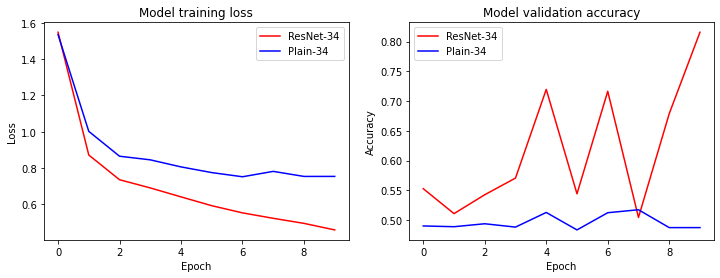

In [41]:
## ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(df_resnet_34['train_loss'], 'r')
plt.plot(df_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_resnet_34['val_acc'], 'r')
plt.plot(df_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

#### ResNet-50 vs Plain-50

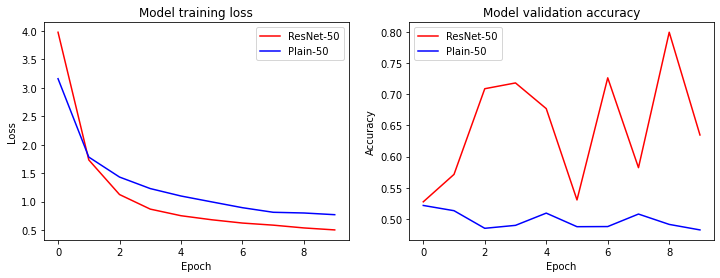

In [44]:
## ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(df_resnet_50['train_loss'], 'r')
plt.plot(df_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_resnet_50['val_acc'], 'r')
plt.plot(df_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()


#### 전체 비교

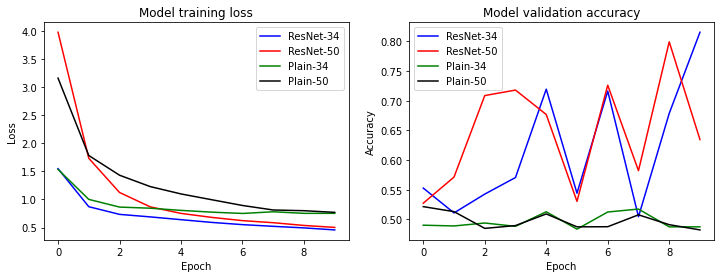

In [45]:
## 전체 비교
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(df_resnet_34['train_loss'], 'b')
plt.plot(df_resnet_50['train_loss'], 'r')
plt.plot(df_plain_34['train_loss'], 'g')
plt.plot(df_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_resnet_34['val_acc'], 'b')
plt.plot(df_resnet_50['val_acc'], 'r')
plt.plot(df_plain_34['val_acc'], 'g')
plt.plot(df_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

#### validation accuracy 비교표

In [47]:
## validation accuracy 비교표
accuracy = {
    'Plain': [round(df_plain_34['val_acc'].mean(), 4),
              round(df_plain_50['val_acc'].mean(), 4)],
    'ResNet': [round(df_resnet_34['val_acc'].mean(), 4), 
               round(df_resnet_50['val_acc'].mean(), 4)]
}

df_acc = pd.DataFrame(accuracy, index=['34 layers', '50 layers'])
df_acc

,Plain,ResNet
34 layers,0.4963,0.6156
50 layers,0.4975,0.6475


In [4]:
## 모델 평가    
## modle.evaluate(ds_test)?

# 회고!

## < 어려웠던 점>  
첫 고잉디퍼였다!! 생각보다 많이 어려웠다... 예시를 보고 맞춰서 내가 직접해야하는게 너무 어려웠고 힘들었다.. 그래서 다른 분들의 코드를 참고해서 짜봤다. ResNet에 대해서 아직까지 너무 부족한 점이 많고 이해력이 조금 부족했던 것 같다! 노드 1을 제대로 못 본 것도 있는 것 같다.. 그리고 VGG처럼 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어보고 ResNet 34와 50이 어떻게 다른지 테스트까지 혼자서 해보는 것이 너무 어려웟다...너무 힘들다,,,ㅠㅠ

## < 알아낸 점> & < 아직까지 모호한 점>  
이번에 뭔가 노드 시작하기 전에 프로젝트 말고 노드를 싹 수완님이 봐주셨는데 한 번 설명을 듣고 프로젝트를 하니까 쫌 나았던 것 같다.   
- 데이터 불러오기 -> 데이터 전처리 -> 모델 설계 -> 모델 학습 -> 모델 평가 -> 모델 베포     

이 틀에 맞춰서 프로젝트를 하는 것도 잘 하지 못했고 낯설었고 사실 무슨 코드가 무슨 단계에 해당하는지 잘 알지 못했다. 근데 이번 기회에 정확히 완전히 아는건 아니지만 감을 대충 잡은 것 같아서 좋았다.! 뭔가 세세한 코드에 대해서 알지는 못해도 큰 흐름을 잘 알 수 있어서 좋았다.!!! 그래서 프로젝트도 그때 설명들은 것 대로 참고해서 해봤다! 

## < 자기 다짐>   
이번에 사실 첨에 코드를 어떻게 짜야하고 코드를 하나하나 어떻게 다 공부를 해야하는지 막막해서 몇 일동안 붙잡고 있었다. 근데 설명도 한 번 듣고 첨에 생각했던 대로 큰 틀만 아는 것으로 넘어가니까 마음이 가벼웠다. 그래서 세세하게 이게 뭔지는 잘 몰라도 이 큰 코드 단락들이 뭘 의미하고 이걸 하면 결과가 어떻게 나온다는 것을 조금 감을 잡아서 다행이다. 그리고 이렇게 단락을 먼저 이해하다 보면 나중에는 코드도 이해를 할 수 있을 것이라고 생각한다! 그러니까 기죽지말고 포기하지말고 ! 화이팅하자!! ** 화이티이잉 :D